In [1]:
import xgi
import igraph as ig
import time
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
H_enron = xgi.load_xgi_data("plant-pollinator-mpl-034")
H_enron_cleaned = H_enron.cleanup(
    multiedges=False, singletons=False, isolates=False, relabel=True, in_place=False
)

In [3]:
k = 2
mxlen = 0
for i in H_enron_cleaned.nodes:
    print(f'Node {i} contains {H_enron_cleaned.nodes.memberships(i)}')
    if (len(H_enron_cleaned.nodes.memberships(i)) > mxlen):
        mxlen = len(H_enron_cleaned.nodes.memberships(i))
print(mxlen)

Node 0 contains {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Node 1 contains {0, 1, 2, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 45, 46, 47, 48}
Node 2 contains {23, 6, 22, 24, 25}
Node 3 contains {1, 26}
Node 4 contains {0, 1, 2, 7}
Node 5 contains {0, 1, 2, 4, 7, 26, 27}
Node 6 contains {0, 1, 7, 10, 17, 20, 21, 24, 28, 29, 30}
Node 7 contains {0, 26, 14, 31}
Node 8 contains {0, 1, 6, 10, 15, 17, 21, 23, 26, 28, 30, 32, 33, 34, 47, 48, 49, 50}
Node 9 contains {0, 1, 2, 4}
Node 10 contains {0, 33, 2, 3, 34, 35, 36, 7, 37, 12, 27}
Node 11 contains {0, 1, 18, 4, 20, 38, 30}
Node 12 contains {0, 1, 4, 5, 7, 10, 12, 15, 17, 18, 21, 32, 35, 36, 37, 38, 39, 40, 41, 42, 49}
Node 13 contains {1, 14}
Node 14 contains {1, 14}
Node 15 contains {1, 26}
Node 16 contains {0, 1, 3, 4, 6, 7, 9, 10, 12, 15, 16, 17, 18, 21, 24, 25, 27, 32, 34, 38, 39, 40, 43, 44, 46}
Node 17 contains {0, 1, 34, 35, 4, 7, 41, 10, 12, 21, 31}
Node 18 contains {0, 1, 32, 4, 6, 7, 41, 42, 44, 45, 15, 51, 22, 27}
N

In [4]:
start_time = time.time()

xgi.centrality.line_vector_centrality(H_enron_cleaned)

middle_time = time.time()

xgi.centrality.fast_line_vector_centrality(H_enron_cleaned)

end_time = time.time()

print(f"Время выполнения nx: {(middle_time-start_time):.6f} секунд")
print(f"Время выполнения ig: {(end_time-middle_time):.6f} секунд")

Время выполнения nx: 0.002020 секунд
Время выполнения ig: 0.000993 секунд


In [5]:
start_time = time.time()

cent_nx = xgi.centrality.line_vector_centrality(H_enron_cleaned)

middle_time = time.time()

cent_ig = xgi.centrality.fast_line_vector_centrality(H_enron_cleaned)

end_time = time.time()

print(f"Время выполнения nx: {(middle_time-start_time):.6f} секунд")
print(f"Посчитанная центральность nx: {cent_nx}")
print(f"Время выполнения ig: {(end_time-middle_time):.6f} секунд")
print(f"Посчитанная центральность ig: {cent_ig}")

Время выполнения nx: 0.002001 секунд
Посчитанная центральность nx: {0: [np.float64(0.16203291818075102), np.float64(0.04268734358878029), np.float64(0.0), np.float64(0.029058143993119984), np.float64(0.0), np.float64(0.05022783099557644), np.float64(0.0), np.float64(0.018146745810559882), np.float64(0.016987653865031767), np.float64(0.0), np.float64(0.0), np.float64(0.013756143884421316), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.010230012571082948), np.float64(0.0), np.float64(0.0), np.float64(0.008768582203785385)], 1: [np.float64(0.3505025485510877), np.float64(0.13908664298186058), np.float64(0.022665806444594042), np.float64(0.09986184487791816), np.float64(0.08974999691086223), np.float64(0.025622760683944444), np.float64(0.0), np.float64(0.018146745810559882), np.float64(0.016987653865031767), np.float64(0.0), np.float64(0.0), np.float64(0.013756143884421316), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.

### с графами

14
ig eigenvector centrality: [0.408248290463863, 0.7071067811865477, 0.4082482904638631, 0.40824829046386313]
nx eigenvector centrality: {0: 0.40824823454557924, 1: 0.707106878039843, 2: 0.40824823454557924, 3: 0.40824823454557924}


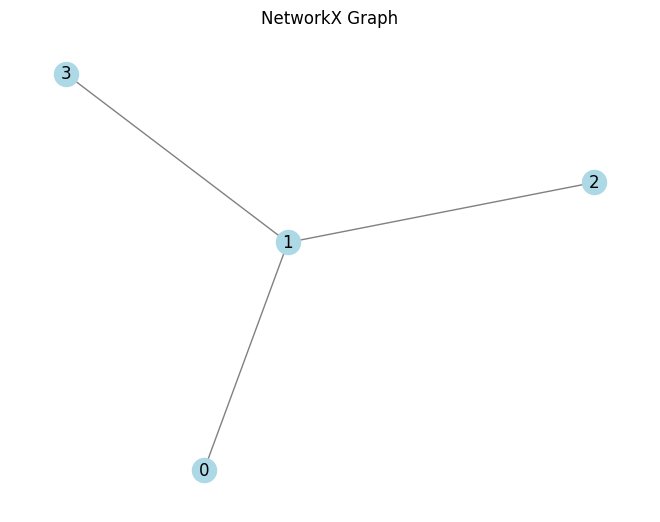

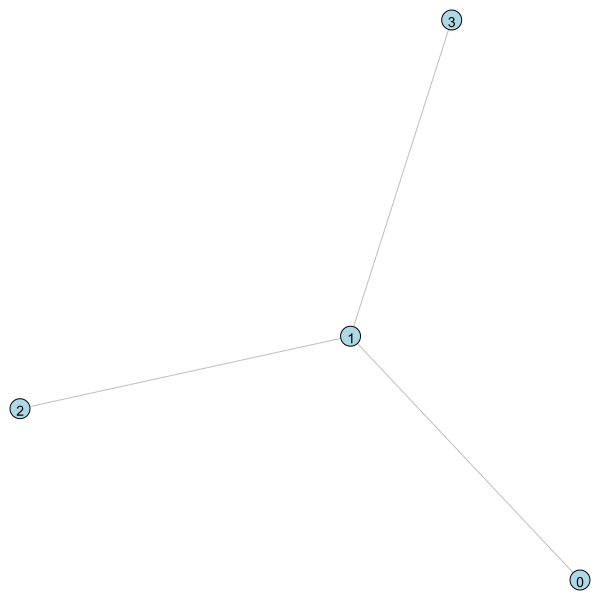

In [6]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt

# Создаем граф
G = nx.Graph()
g = ig.Graph()

# Добавляем узлы
G.add_nodes_from([0, 1, 2, 3])
g.add_vertices(4)  # Добавляем 4 узла

# Добавляем рёбра
G.add_edges_from([(0, 1), (1, 2), (1, 3)])
g.add_edges([(0, 1), (1, 2), (1, 3)])

nx_centrality = nx.eigenvector_centrality(G)
print(sum([i**2 for i in nx_centrality]))
ig_centrality = g.eigenvector_centrality(scale=False)
# normalized_ig_values = [value / max_ig_value for value in ig_centrality]

print(f'ig eigenvector centrality: {ig_centrality}')
print(f'nx eigenvector centrality: {nx_centrality}')

nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("NetworkX Graph")
plt.show()

layout = g.layout("kk")
ig.plot(g, layout=layout, vertex_label=g.vs.indices, vertex_color="lightblue", edge_color="gray")


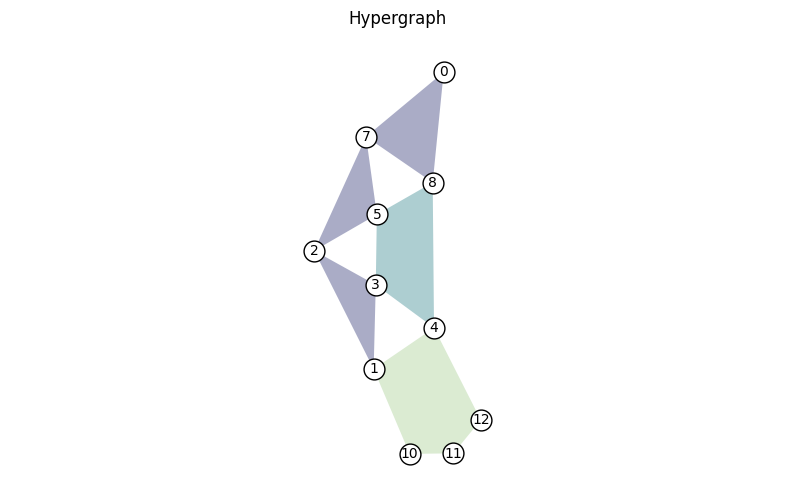

In [7]:

import xgi
import numpy as np
import matplotlib.pyplot as plt
from igraph import plot,Graph


hg = xgi.Hypergraph()
hg.add_edges_from(
    [[1, 2, 3], [3, 4, 5,8], [1, 4, 10, 11, 12], [7,0,8], [5,7,2]]
)
pos = xgi.barycenter_spring_layout(hg)


fig, ax = plt.subplots(figsize=(10,6))
xgi.draw(hg, ax=ax,node_labels=True,node_size=15,pos=pos)
plt.title("Hypergraph")
plt.show()

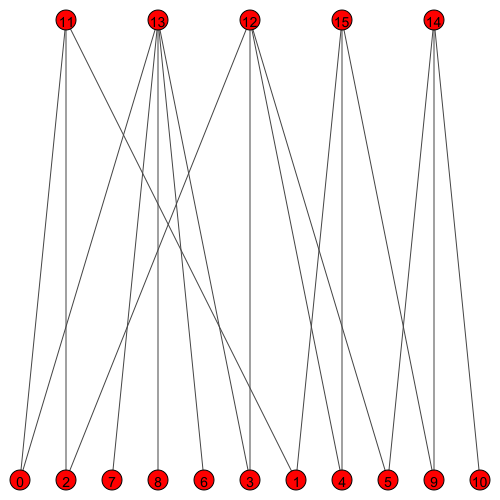

In [8]:
bpg = xgi.convert.to_bipartite_graph(hg)

#layout = bpg.layout_kamada_kawai()
# fig, ax=plt.subplots()
plot(bpg,vertex_label=bpg.vs.indices,layout = Graph.layout_bipartite(bpg), bbox=(0, 0, 500,500))

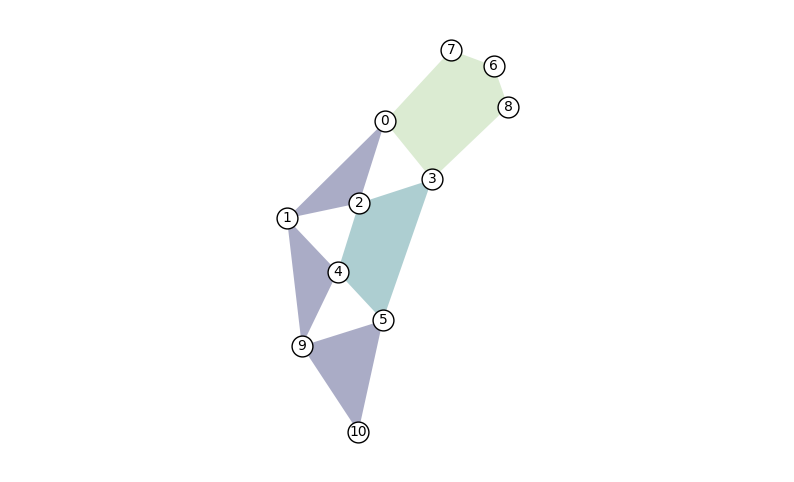

In [14]:
hypergraph  = xgi.from_bipartite_graph(bpg)
pos = xgi.barycenter_spring_layout(hypergraph)

fig, ax = plt.subplots(figsize=(10,6))
xgi.draw(hypergraph, ax=ax,node_labels=True,node_size=15,pos=pos)
plt.show()